In [ ]:
!!apt install unzip

['',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 74%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading pack

In [ ]:
!unzip  archive.zip -d leaf-data

Archive:  archive.zip
  inflating: leaf-data/test/leaf/TEST_001.jpg  
  inflating: leaf-data/test/leaf/TEST_002.jpg  
  inflating: leaf-data/test/leaf/TEST_003.jpg  
  inflating: leaf-data/test/leaf/TEST_004.jpg  
  inflating: leaf-data/test/leaf/TEST_005.jpg  
  inflating: leaf-data/test/leaf/TEST_006.jpg  
  inflating: leaf-data/test/leaf/TEST_007.jpg  
  inflating: leaf-data/train.csv     
  inflating: leaf-data/train/LEAF_0009.jpg  
  inflating: leaf-data/train/LEAF_0010.jpg  
  inflating: leaf-data/train/LEAF_0011.jpg  
  inflating: leaf-data/train/LEAF_0012.jpg  
  inflating: leaf-data/train/LEAF_0013.jpg  
  inflating: leaf-data/train/LEAF_0014.jpg  
  inflating: leaf-data/train/LEAF_0015.jpg  
  inflating: leaf-data/train/LEAF_0016.jpg  
  inflating: leaf-data/train/LEAF_0017.jpg  
  inflating: leaf-data/train/LEAF_0018.jpg  
  inflating: leaf-data/train/LEAF_0019.jpg  
  inflating: leaf-data/train/LEAF_0020.jpg  
  inflating: leaf-data/train/LEAF_0021.jpg  
  inflating: leaf-d

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 17kB/s 
     |████████████████████████████████| 4.0MB 22.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 15.9MB/s 
     |████████████████████████████████| 952kB 31.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=2e0cb56484033b333bb1ec2ec9730778f95cf8c9747f42eee765e3c932de1dde
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import time

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch import transforms

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


DIR_INPUT = 'leaf-data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Loading the device now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


Found GPU at: /device:GPU:0


# Reading and parsing the CSV

In [ ]:
train_df = pd.read_csv(os.path.join(DIR_INPUT,"train.csv"))


In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1471054520958462895, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13960785472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13632597721157821356
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-4:]
valid_ids = np.append(valid_ids,image_ids[:4])
train_ids = image_ids[4:-4]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

((195, 7), (5151, 7))

In [ ]:
class LeafDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)                
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# This Albumentation for now it is empty.
def transform():
    return A.Compose([        
#         A.Cutout(num_holes=10,max_h_size=15,max_w_size=15,p=1),
            
#         A.OneOf([
#             A.RandomSunFlare(src_radius=200,num_flare_circles_lower=6,num_flare_circles_upper=8,p=1),
#             A.RandomRain(slant_lower=-10,slant_upper=10,drop_length=20,drop_width=1,p=1),
#             A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.1, alpha_coef=0.08, p=1),  
#         ], p=1),
#         A.OneOf([
#             A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=1),
#             A.RandomGamma(gamma_limit=(80,165),p=1),  
#         ], p=1),      
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)


In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [ ]:
# HELPER FUNCTIONS FOR VIZUALISING / PREDICTING

def get_boxes(tensor,index,score=0.5):

    if index >= len(tensor)  or index<0:
        return 0
    
    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))    
        
    return temp_boxes    
def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')
def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()

    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    boxes = get_boxes(outputs,0)


    # boxes = outputs[1]['boxes'].cpu().detach().numpy().astype(np.int32)


    sample = images[0].permute(1,2,0).cpu().numpy()
    
    boxes = get_boxes(outputs,0)

    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)


    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')
    
def load_test_dataset():
    data_path = DIR_TEST
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))
    
    test_loader = torch.utils.data.DataLoader(    
        test_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )
    return test_loader

def get_test_image(itr,score = 0.5):
    image, targets= next(itr)
    sample = image
    
    image = image.to(device)
    model.eval()
    outputs = model(image)
    
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]   
    
    boxes = get_boxes(outputs,0,score)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    print(sample.shape)
    img = sample[0].permute(1,2,0).cpu().numpy()
    print(img.shape)
    
    
    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    print(img.shape)
    for box in boxes:
        x,y,w,h = box
        
        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')


# Sample of training data augumented


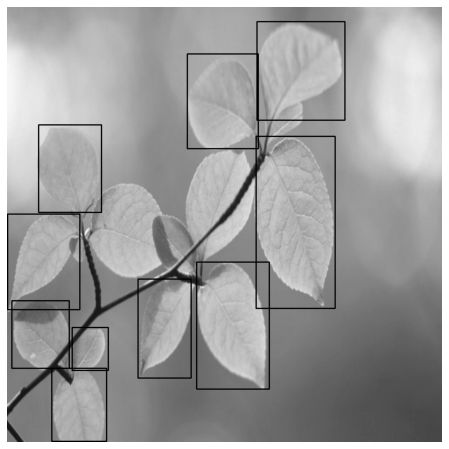

In [ ]:
it = iter(train_data_loader)
get_sample_image(it)

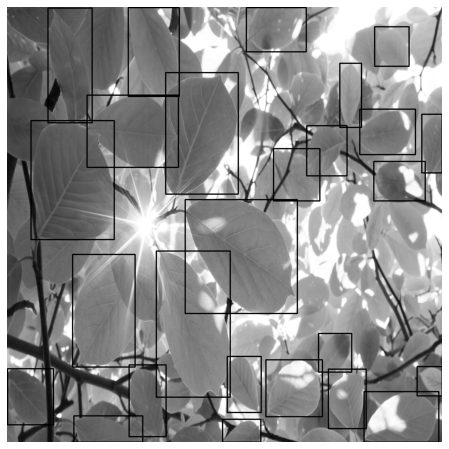

In [ ]:
get_sample_image(it)

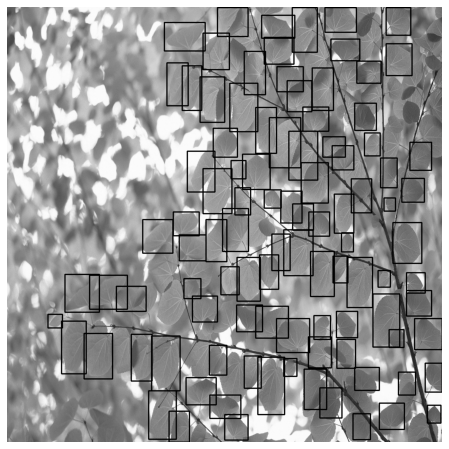

In [ ]:
get_sample_image(it)

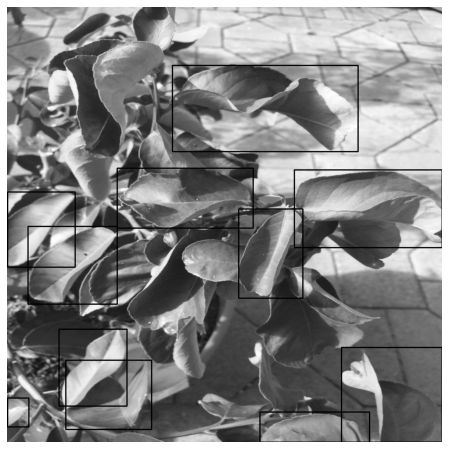

In [ ]:
get_sample_image(it)

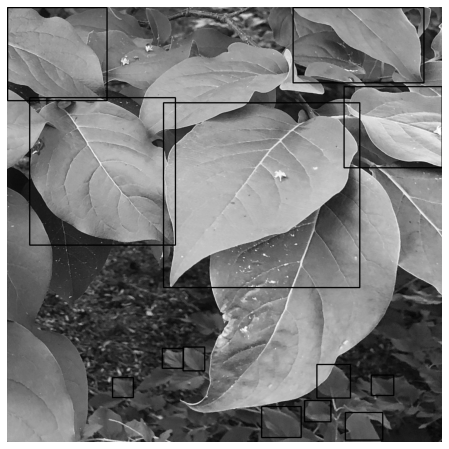

In [ ]:
get_sample_image(it)

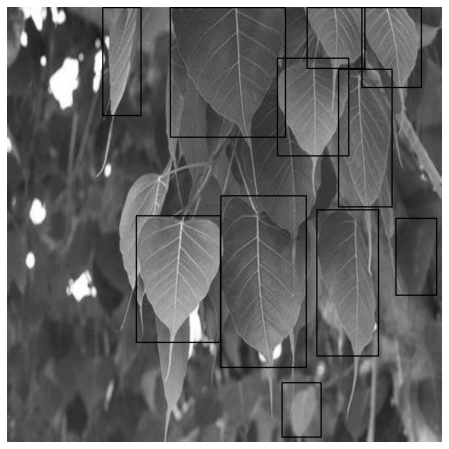

In [ ]:
get_sample_image(it)

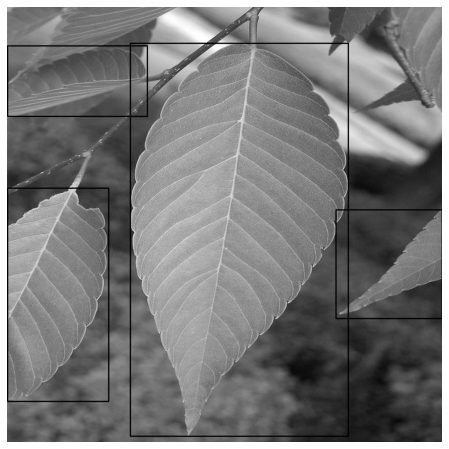

In [ ]:
get_sample_image(it)

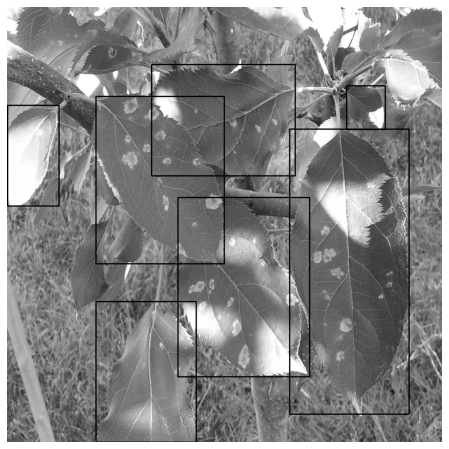

In [ ]:
get_sample_image(it)

# Loading ResNet50 trained on COCO

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [ ]:

num_classes = 2  # 1 class (leaf) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [ ]:
model.to(device)
print(model.to(device))
print("Model loaded")

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

# Training

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None

num_epochs = 15

In [ ]:
loss_hist = Averager()
itr = 1

previous_epoch = 1000
es_rate = 0

es_threshold = 2 # How many epochs without improvement to early stop


for epoch in range(num_epochs):
    loss_hist.reset()
    min_loss = 1000
    for images, targets, image_ids in train_data_loader:
       
        images = list(image.to(device) for image in images)
       
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
       
        loss_dict = model(images, targets)
      
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        
        itr += 1
                
            
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    min_loss = loss_hist.value
    
    if min_loss < previous_epoch:
        previous_epoch = min_loss
        es_rate = 0
        
    else:
        if es_rate < es_threshold:
            es_rate += 1
        elif es_rate >= es_threshold:
            break
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   


Iteration #50 loss: 0.20279733836650848
Iteration #100 loss: 0.43754175305366516
Iteration #150 loss: 0.578862190246582
Iteration #200 loss: 0.1281128078699112
Iteration #250 loss: 0.24698138236999512
Epoch #0 loss: 0.33583516860877916
Iteration #300 loss: 0.40320155024528503
Iteration #350 loss: 0.20936338603496552
Iteration #400 loss: 0.2824775278568268
Iteration #450 loss: 0.17050236463546753
Iteration #500 loss: 0.27773404121398926
Iteration #550 loss: 0.22117286920547485
Epoch #1 loss: 0.2503366733427256
Iteration #600 loss: 0.13425609469413757
Iteration #650 loss: 0.3931565284729004
Iteration #700 loss: 0.0673854798078537
Iteration #750 loss: 0.32764166593551636
Iteration #800 loss: 0.14250342547893524
Epoch #2 loss: 0.21178911499069256
Iteration #850 loss: 0.3078716993331909
Iteration #900 loss: 0.2289292812347412
Iteration #950 loss: 0.22201097011566162
Iteration #1000 loss: 0.08998927474021912
Iteration #1050 loss: 0.17493999004364014
Iteration #1100 loss: 0.08843015134334564


In [ ]:
print(loss_dict)

[{'boxes': tensor([[4.1682e+02, 4.4159e+02, 6.7705e+02, 7.3210e+02],
        [3.5457e+02, 5.6143e+02, 5.2827e+02, 9.1745e+02],
        [3.6789e+02, 1.3597e+02, 5.4634e+02, 4.4563e+02],
        [6.5497e+01, 2.5912e+02, 2.5349e+02, 5.5574e+02],
        [1.9531e+02, 2.0259e+02, 4.0178e+02, 3.8294e+02],
        [2.8698e+02, 8.4054e+02, 3.7329e+02, 1.0123e+03],
        [6.0104e+02, 8.4237e+02, 7.4032e+02, 9.8654e+02],
        [7.5741e+02, 8.5254e+02, 8.4471e+02, 1.0055e+03],
        [8.2459e+02, 2.3795e+02, 9.5931e+02, 3.6205e+02],
        [7.0603e+02, 2.7282e+02, 7.9546e+02, 4.1291e+02],
        [2.4754e-01, 8.4448e+02, 1.0254e+02, 9.9575e+02],
        [8.4723e+02, 9.0127e+02, 1.0136e+03, 1.0219e+03],
        [8.1283e+02, 7.0627e+02, 8.8167e+02, 8.6920e+02],
        [2.8918e+02, 0.0000e+00, 4.0562e+02, 2.0742e+02],
        [5.1869e+02, 8.1772e+02, 5.9619e+02, 9.5574e+02],
        [7.3140e+02, 7.5943e+02, 8.0854e+02, 8.7827e+02],
        [6.4010e+02, 3.3349e+02, 7.4319e+02, 4.7653e+02],
   

# Validation (On data from Training)

In [ ]:
it = iter(valid_data_loader)

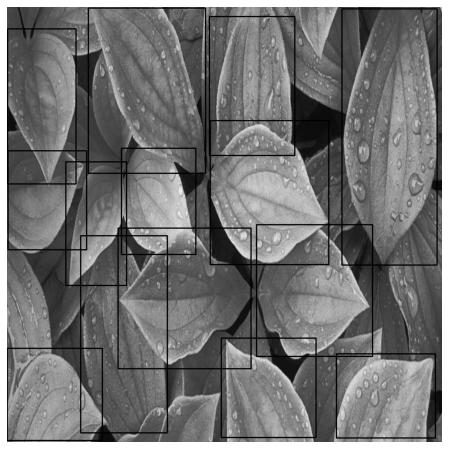

In [ ]:
get_validation_image(it)

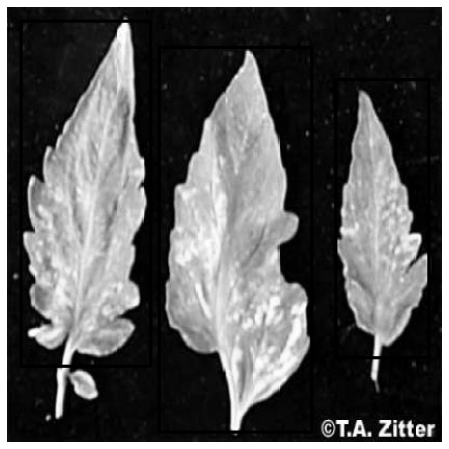

In [ ]:
get_validation_image(it)

In [139]:
get_validation_image(it)

StopIteration: ignored

In [ ]:
get_validation_image(it)

StopIteration: ignored

In [ ]:
get_validation_image(it)

StopIteration: ignored

In [ ]:
get_validation_image(it)

StopIteration: ignored

In [ ]:
get_validation_image(it)

StopIteration: ignored

In [ ]:
get_validation_image(it)

StopIteration: ignored

# Testing

In [ ]:
image_list = os.listdir(DIR_TEST+"/leaf")
print(image_list)

['TEST_004.jpg', 'TEST_002.jpg', 'TEST_006.jpg', 'TEST_001.jpg', 'TEST_005.jpg', 'TEST_007.jpg', 'TEST_003.jpg']


In [ ]:
it = iter(load_test_dataset())


torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.18008732795715332


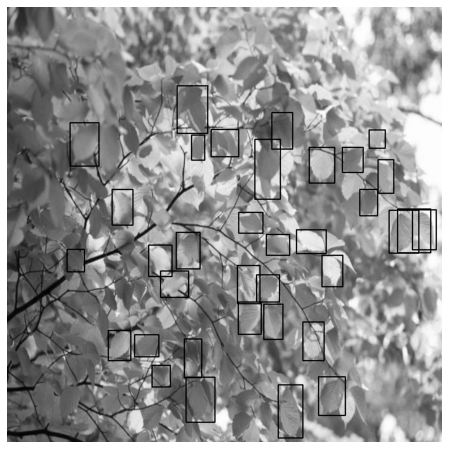

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.16802620887756348


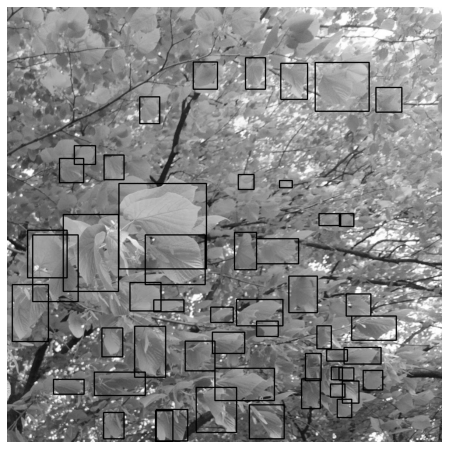

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.15855002403259277


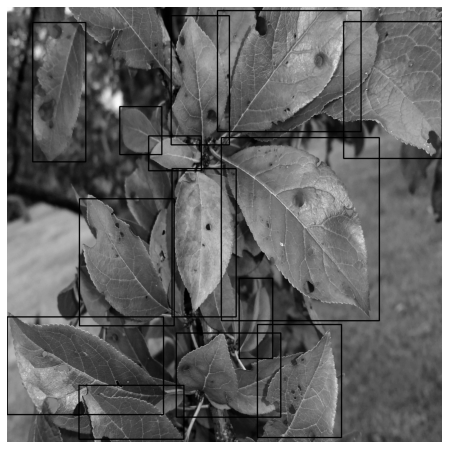

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.16949057579040527


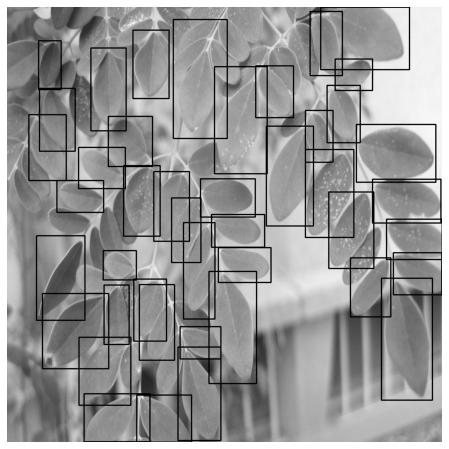

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.17716693878173828


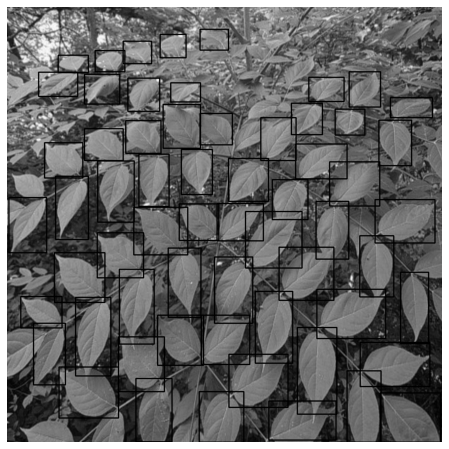

In [ ]:
start = time.time()
get_test_image(it,0.5)
print(time.time()-start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.15856075286865234


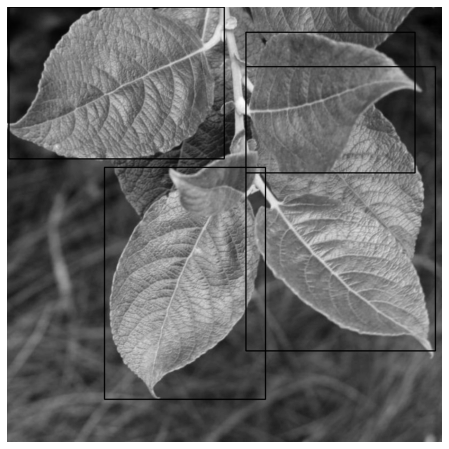

In [ ]:
start = time.time()
get_test_image(it,0.50)
print(time.time()-start)

torch.Size([1, 1, 1024, 1024])
(1024, 1024, 1)
(1024, 1024)
0.1591043472290039


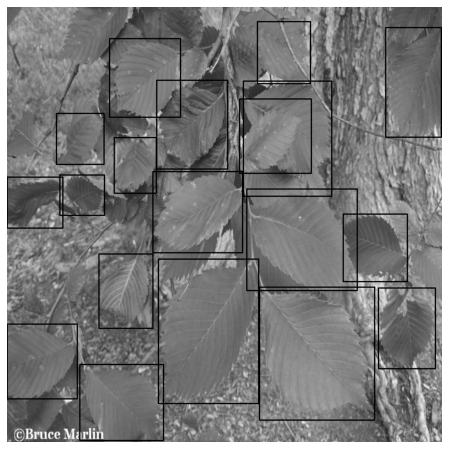

In [ ]:
start = time.time()
get_test_image(it,0.50)
print(time.time()-start)

In [136]:
torch.save(model, 'leaves_fasterrcnn_model.pth')

In [137]:
filename = 'final_model.sav'

In [138]:
torch.save(model, filename)

## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Edit Notebook" button at the top of the kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!